# Here, we demonstrate how we perform variance partitioning analysis

In [1]:
source("my.source.R")
options(stringsAsFactors=F)
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(lme4))
suppressPackageStartupMessages(library(variancePartition))

In [12]:
celltype_reordered_27 = c("B05_NCD4","B06_MCD4","B01_Th1","B02_Th2","B03_TH17","B04_Tfh","B09_Fra1","B07_aTreg","B10_Fra3","C01_NCD8","C04_CmCD8","C05_EmCD8","C03_EffectorCD8","G01_NK","A01_NaiB","A03_UnswMB","A02_SwiMB","A04_DNB","A05_PB","E02_CD16nMo","E01_CD16pMo","E04_Intermediate","E03_NonClassical","D01_mDC","D02_pDC","F01_Neu","F02_LDG")
label = c(`B05_NCD4`="Naive CD4",`B06_MCD4`="Mem CD4",`B01_Th1`="Th1",`B02_Th2`="Th2",`B03_TH17`="Th17",`B04_Tfh`="Tfh",
          `B09_Fra1`="Fr. I nTreg",`B07_aTreg`="Fr. II eTreg",`B10_Fra3`="Fr. III T",
          `C01_NCD8`="Naive CD8",`C04_CmCD8`="CM CD8",`C05_EmCD8`="EM CD8",`C03_EffectorCD8`="TEMRA CD8",`G01_NK`="NK",
          `A01_NaiB`="Naive B",`A03_UnswMB`="USM B",`A02_SwiMB`="SM B",`A04_DNB`="DN B",`A05_PB`="Plasmablast",
          `E02_CD16nMo`="CL Mono",`E01_CD16pMo`="CD16p Mono",`E04_Intermediate`="Int Mono",`E03_NonClassical`="NC Mono",
          `D01_mDC`="mDC",`D02_pDC`="pDC",
          `F01_Neu`="Neu",`F02_LDG`="LDG")
label_df = as.data.frame(label) %>% rownames_to_column("subset")
labeller = as_labeller(label)
celltype_corresp=fread_FT("data_ref/COI_27subset_color_list.txt")

## Make demodata
### Assume the situation in which only disease activity contribute the data variation within SLE in PC1 of one cell type
### We prepare inactive(n=10), LDA(n=10),MDA(n=10) and HDA(n=10)

In [83]:
Metadata=data.frame(ID=paste0("SLE",c(1:40)%>%formatC(width=2,flag="0")),
                                      Activity=c(rep("inactive",10),rep("LDA",10),rep("MDA",10),rep("HDA",10)),
                                      age=rpois(40,45),      # integer at random, similar to actual data
                                      sex=rep(c(rep("0Female",9),"1Male"),4), # For each activity group, female:male = 9:1
                                      PSLmg=rpois(40,5), # integer at random, mean 5mg/day 
                                      HCQ=rbinom(40,1,0.5), # 50% at random
                                      MMF=rbinom(40,1,0.25), # 25% at random
                                      TAC=rbinom(40,1,0.2))    # 20% at random

In [94]:
Metadata=Metadata%>%mutate(Immunosuppressant=ifelse(HCQ==0&MMF==0&TAC==0,"0No",
                                                             ifelse(HCQ==1&MMF==0&TAC==0,"1HCQ",
                                                             ifelse(HCQ==0&MMF==1&TAC==0,"2MMF",
                                                             ifelse(HCQ==0&MMF==0&TAC==1,"3TAC",
                                                             ifelse(HCQ==1&MMF==1&TAC==0,"4HCQMMF",
                                                             ifelse(HCQ==1&MMF==0&TAC==1,"5HCQTAC",
                                                             ifelse(HCQ==0&MMF==1&TAC==1,"6MMFTAC","7HCQMMFTAC")))))))) 

In [95]:
head(Metadata)

,ID,Activity,age,sex,PSLmg,HCQ,MMF,TAC,Immunosuppressant
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>
1,SLE01,inactive,37,0Female,2,1,0,0,1HCQ
2,SLE02,inactive,35,0Female,4,0,1,0,2MMF
3,SLE03,inactive,46,0Female,2,0,0,1,3TAC
4,SLE04,inactive,41,0Female,4,1,0,0,1HCQ
5,SLE05,inactive,48,0Female,4,1,0,0,1HCQ
6,SLE06,inactive,41,0Female,9,1,0,0,1HCQ


In [96]:
PCdata=Metadata%>%select(ID,Activity)%>%
                                        mutate(PC1=ifelse(Activity=="inactive",-15,
                                                                ifelse(Activity=="LDA",-5,
                                                                ifelse(Activity=="MDA",5,
                                                                ifelse(Activity=="HDA",15,NA)))))%>%
                                        mutate(PC1=PC1+rnorm(40,mean=0,sd=2))%>%  # Add the standard error
                                        select(-Activity)

In [97]:
head(PCdata)

,ID,PC1
,<chr>,<dbl>
1,SLE01,-11.27469
2,SLE02,-17.25258
3,SLE03,-17.53857
4,SLE04,-16.39624
5,SLE05,-18.36535
6,SLE06,-13.11855


## First, we manually construct lmm and calculate the explained variance

In [98]:
data_tmp=left_join(PCdata,Metadata,by="ID")

#### To estimate the variance from linear mixed model, maximum likelihood (ML) method (not REML) is suitable (https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1323-z)

In [100]:
ML  = lmer(PC1 ~ (1|Activity)+PSLmg+(1|Immunosuppressant)+age+(1|sex), data_tmp, REML = FALSE, verbose = FALSE, na.action = na.omit)

In [102]:
VarCorr(ML)

 Groups            Name        Std.Dev.
 Immunosuppressant (Intercept)  0.39325
 Activity          (Intercept) 11.62248
 sex               (Intercept)  0.62511
 Residual                       2.18604

In [105]:
unlist(VarCorr(ML)) # Random effect terms, variance

Immunosuppressant          Activity               sex 
        0.1546435       135.0820211         0.3907679

In [106]:
attr(VarCorr(ML), "sc") # Residual term, sd

[1] 2.186044

In [107]:
Var_Random_effect = unlist(VarCorr(ML))
Var_Residual = attr(VarCorr(ML), "sc")^2
Var_Ramdom   = c(Var_Random_effect,Var_Residual)

In [110]:
Var_Ramdom

Immunosuppressant          Activity               sex                   
        0.1546435       135.0820211         0.3907679         4.7787886

In [108]:
coef(summary(ML)) # fixed effect terms

,Estimate,Std. Error,t value
(Intercept),3.99952147,6.41623423,0.6233441
PSLmg,-0.05736015,0.16312581,-0.3516314
age,-0.07807038,0.05620809,-1.3889527


#### for fixed effects, variance explained(r^2) = beta^2 * var(x)/var(y)

In [109]:
beta_Fixed_effect = coef(summary(ML))[2:3,1]
var_Fixed_effect  = c(var(data_tmp$PSLmg),var(data_tmp$age))
Var_Fixed = (beta_Fixed_effect^2) * var_Fixed_effect

In [111]:
Var_Fixed

PSLmg        age 
0.01668504 0.25298480

In [112]:
Var_all=c(Var_Ramdom,Var_Fixed)
Sum_all   = sum(Var_all)
Var_all_std = data.frame(Var_all/Sum_all) %>%t() %>% as.data.frame()
colnames(Var_all_std) = c("Immunosuppressant","Activity","Sex","residual","PSL","Age")
rownames(Var_all_std) = "PC1"

In [113]:
Var_all_std

,Immunosuppressant,Activity,Sex,residual,PSL,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PC1,0.001099289,0.9602358,0.002777789,0.0339702,0.0001186063,0.001798352


## Next, we use variancePartion package

In [116]:
PCdata2=PCdata%>%column_to_rownames("ID")%>%
                                      t() %>% as.data.frame()

In [118]:
headd(PCdata2)

,SLE01,SLE02,SLE03,SLE04,SLE05
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PC1,-11.27469,-17.25258,-17.53857,-16.39624,-18.36535


In [119]:
form = ~ (1|Activity)+PSLmg+(1|Immunosuppressant)+age+(1|sex)
varPart = fitExtractVarPartModel( PCdata2, form, Metadata ) %>% as.data.frame()

Dividing work into 1 chunks...




Total:1 s



In [120]:
varPart

,Activity,Immunosuppressant,sex,PSLmg,age,Residuals
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PC1,0.9602455,0.001099301,0.002777817,0.0001179787,0.001788837,0.03397055


#### Almost identical with manually calculated results!!

## In actual data analysis, we used variancePartition package

### Total variance partition

In [8]:
condition_clinical= read.table_FT("data/SLEinc_andHC/211124_COI_SLEinc_andHC_27subsets_cond_wclinical.txt") %>% 
                    mutate(Immunosuppressant=ifelse(HCQ=="0No"&MMF=="0No"&TAC=="0No","0No",
                                             ifelse(HCQ=="1Yes"&MMF=="0No"&TAC=="0No","1HCQ",
                                             ifelse(HCQ=="0No"&MMF=="1Yes"&TAC=="0No","2MMF",
                                             ifelse(HCQ=="0No"&MMF=="0No"&TAC=="1Yes","3TAC",
                                             ifelse(HCQ=="1Yes"&MMF=="1Yes"&TAC=="0No","4HCQMMF",
                                             ifelse(HCQ=="1Yes"&MMF=="0No"&TAC=="1Yes","5HCQTAC",
                                             ifelse(HCQ=="0No"&MMF=="1Yes"&TAC=="1Yes","6MMFTAC","7HCQMMFTAC")))))))) 

name_list = condition_clinical %>%select(name,id,disease,subset,lotseq,age,gender,Activity,constitutional,mucocutaneous,musculoskeletal,renal,extrarenal,hematological,serological,PSLmg,Immunosuppressant,HCQ,MMF,TAC) 
name_list$disease  = factor(name_list$disease,levels=c("0HC","1SLE"))
name_list$lotseq 　= factor(name_list$lotseq,levels=c("Lot3_HiSeq","Lot1_HiSeq","Lot2_HiSeq","Lot4_HiSeq","Lot5_HiSeq","Lot5_NovaSeq"))
name_list$Activity = factor(name_list$Activity,levels=c("0HC","1Inactive","2LDA","3MDA","4HDA"))
name_list$Immunosuppressant = factor(name_list$Immunosuppressant,levels=sort(unique(name_list$Immunosuppressant)))

name_list_SLE=name_list%>%filter(disease=="1SLE")

In [7]:
list = fread_FT("tmp_job_list/211128_COI_SLEuniqueandHC_27subsets_AfterCombat_PCres_list.txt")

In [10]:
for (kkk in 1:nrow(list)){ 
    subset_tmp=list$subset[kkk] # Each cell type
    load(list$PATH[kkk])
    cumvar = summary(result)$importance[,1:7] %>% as.data.frame() # eigenvalue
    cumvar_sum = cumvar[3,7]
    
   # PC 1-7 data
    Matrix=as.data.frame(result$x) %>% select(1:7) %>% t() %>% as.data.frame() 
    # Metadata
    Metadata=name_list_SLE%>%filter(name%in%colnames(Matrix))%>%select(-id)
    Matrix=Matrix[,Metadata$name]

    Metadata$name=factor(Metadata$name,levels=colnames(Matrix))
    Metadata=Metadata[order(Metadata$name),]
    Metadata$name=as.character(Metadata$name)

    all.equal(colnames(Matrix),Metadata$name) %>% print()
    
   # variance partition
    form = ~ (1|Activity)+PSLmg+(1|Immunosuppressant)+age+(1|gender)
    varPart = fitExtractVarPartModel( Matrix, form, Metadata ) %>% as.data.frame()
    
    # Caluculate  the average value of the explained variance weighted by each PC’s eigenvalue (PC1-7) 
    varPart_weighed=varPart
  for (iii in 1:7){
     PC_tmp   = rownames(varPart)[iii]
     Prop_raw = cumvar %>% select(all_of(PC_tmp)) %>%.[2,]
     Prop_std = Prop_raw/cumvar_sum
     varPart_weighed[iii,]=varPart[iii,]*Prop_std
   }
     colnames(varPart_weighed) = c("Activity","Sex","Immunosuppressant","PSL","Age","residual")
     varPart_weighed_sum=apply(varPart_weighed,2,sum) %>% as.data.frame() %>% t() %>% as.data.frame()
     varPart_weighed_sum$subset=subset_tmp
     if(kkk==1){varPart_weighed_sum2=varPart_weighed_sum}else{varPart_weighed_sum2=rbind(varPart_weighed_sum2,varPart_weighed_sum)}
  }

Total_sum=varPart_weighed_sum2 %>% select(subset,Activity,PSL,Immunosuppressant,Age,Sex)
Total_sum_ordered=Total_sum[order(Total_sum$Activity),]

[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:4 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



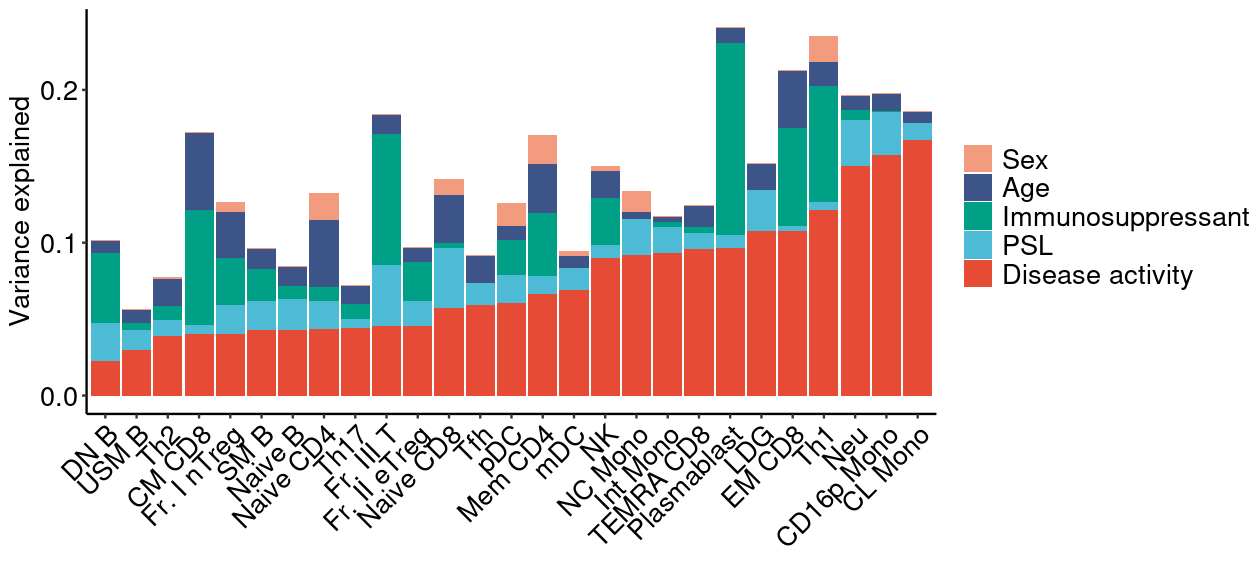

In [14]:
Total_sum_ordered$subset = factor(Total_sum_ordered$subset,levels=Total_sum_ordered$subset)
Total_sum2 = Total_sum_ordered %>% pivot_longer(col=-subset,names_to="parameter",values_to="value")
Total_sum2$parameter = factor(Total_sum2$parameter,levels=rev(unique(Total_sum2$parameter)))
levels(Total_sum2$parameter)=list(`Sex`="Sex",`Age`="Age",`Immunosuppressant`="Immunosuppressant",`PSL`="PSL",`Disease activity`="Activity")
Total_sum2$subset = factor(Total_sum2$subset,levels=levels(Total_sum_ordered$subset))

col2 = rev(pal_npg("nrc")(5))

# Figure
p2 = ggplot()+
    geom_bar(data=Total_sum2, aes(x=subset,y=value,fill=parameter),
           stat="identity",position="stack")+
    theme_classic()+
    scale_fill_manual(values = col2)+
    theme(axis.text.x=element_text(colour="black",angle=45,hjust=1,vjust=1,size=16),
           axis.text.y=element_text(colour="black",size=16),
           axis.title.x=element_blank(),
           axis.title.y=element_text(colour="black",size=16),
           plot.title=element_blank(),
           legend.position="right",
           legend.title=element_blank(),
           legend.text=element_text(colour="black",size=16))+
     scale_x_discrete(labels= label)+
     scale_y_continuous(breaks= c(0,0.1,0.2))+
    labs(y="Variance explained")

options(repr.plot.width=10.5, repr.plot.height=4.7)
p2 # Fig 2d

In [15]:
mean(Total_sum_ordered$Activity)
Total_sum_ordered$Tx_total=Total_sum_ordered$PSL + Total_sum_ordered$Immunosuppressant
mean(Total_sum_ordered$Tx_total)
Total_sum_ordered$ratio=Total_sum_ordered$Activity/Total_sum_ordered$Tx_total
mean(Total_sum_ordered$ratio)

[1] 0.07554299

[1] 0.0431276

[1] 2.862975

## Jackknife resampling method
## Example: one celltype Naive B

In [16]:
LIST="tmp_job_list/211128_COI_SLEuniqueandHC_27subsets_AfterCombat_PCres_list.txt"

In [17]:
task_id=1
list          = fread_FT(LIST)
subset_tmp    = list[task_id,3]
Rdata_path    = list[task_id,1]

paste0("subset_tmp : ",subset_tmp) %>% print()
paste0("Rdata_path : ",Rdata_path) %>% print()

out_f  = paste0("PCAres_Clinical/variancePartition/jackknife_total/")
out_ff = paste0(today(),"_COI_PC30andClinical_")

load(Rdata_path)
cumvar = summary(result)$importance[,1:7] %>% as.data.frame()
cumvar_sum = cumvar[3,7]

Matrix_full=as.data.frame(result$x) %>% select(1:7) %>% t() %>% as.data.frame()
Matrix_full=Matrix_full[,is.element(colnames(Matrix_full),name_list_SLE$name)]

for (mmm in 1:ncol(Matrix_full)){
     Matrix=Matrix_full[,-mmm] # jackknife -1

    Metadata=name_list%>%filter(name%in%colnames(Matrix))%>%select(-id)
    Metadata$name=factor(Metadata$name,levels=colnames(Matrix))
    Metadata=Metadata[order(Metadata$name),]
    Metadata$name=as.character(Metadata$name)

    all.equal(colnames(Matrix),Metadata$name) %>% print()
   
    form = ~ (1|Activity)+PSLmg+(1|Immunosuppressant)+age+(1|gender)
    varPart = fitExtractVarPartModel( Matrix, form, Metadata )
    varPart_weighed=varPart

  for (iii in 1:7){
     PC_tmp   = rownames(varPart)[iii]
     Prop_raw = cumvar %>% select(all_of(PC_tmp)) %>%.[2,]
     Prop_std = Prop_raw/cumvar_sum
     varPart_weighed[iii,]=varPart[iii,]*Prop_std
   }
     colnames(varPart_weighed) = c("Activity","Sex","Immunosuppressant","PSL","Age","residual")
     varPart_weighed_sum=apply(varPart_weighed,2,sum) 
     varPart_weighed_sum=data.frame(varPart_weighed_sum)%>% t()
     rownames(varPart_weighed_sum) = paste0("test",mmm)

     if(mmm==1){varPart_weighed_jack=varPart_weighed_sum}else{varPart_weighed_jack=rbind(varPart_weighed_jack,varPart_weighed_sum)}
}

[1] "subset_tmp : A01_NaiB"
[1] "Rdata_path : PCA_res/SLEunique_andHC/AfterCombat/filter10000/tmp_Rdata/211124_COI_SLEunique_andHC_AfterCombat_filter10000_A01_NaiB_PCAres_tmp1.Rdata"
[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:5 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



[1] TRUE


Dividing work into 1 chunks...


Total:6 s



## jackknife all cell types list (Total)

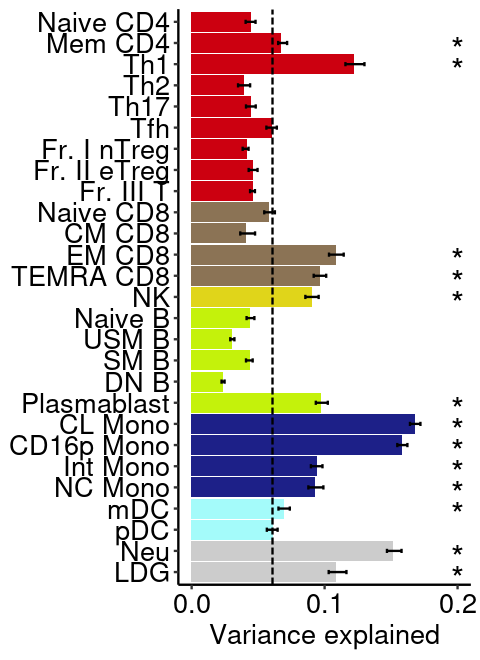

In [23]:
list = make_list("PCAres_Clinical/variancePartition/jackknife_total","_varPartjack_total.txt")
list$subset = take_factor(list$FILE,5:6,"_")
Total_sum_ordered=fread_FT("PCAres_Clinical/variancePartition/211222_COI_PC30andClinical_varPart_Total_auto.txt")
median =median(Total_sum_ordered$Activity)

col2=c("CD4"="#cc0010","CD8"="#8b7355","NK"="#e0d51a","B"="#c4f20b","Monocyte"="#1d2088","DC"="#a4fbfa","Neutrophil"="#cccccc")

# summarise results
for (kkk in 1:nrow(list)){
    subset_tmp= list$subset[kkk]
    perc_tmp  = fread_FT(list$PATH[kkk]) %>% select(test,Activity)
    percentile=quantile(perc_tmp$Activity,probs=c(0.025,0.975),na.rm=T) %>% as.data.frame() %>% rownames_to_column("test")
    colnames(percentile)[2]="Activity"
    perc_tmp=rbind(perc_tmp,percentile)
    perc_tmp$subset=subset_tmp
    perc_tmp=perc_tmp %>% select(subset,test,Activity)
    orig_tmp  = Total_sum_ordered %>% filter(subset==subset_tmp) %>% 
                                      mutate(test="orig") %>% select(subset,test,Activity)

    res_tmp=rbind(orig_tmp,perc_tmp) %>% pivot_longer(col=-c(subset,test),names_to="parameter",values_to="value") %>%
                                         pivot_wider(names_from="test",values_from="value") 

    jack_tmp=as.numeric(res_tmp[1,4:(ncol(res_tmp)-2)])
    res_tmp$test_num=(ncol(res_tmp)-5)
    res_tmp$smaller_num=length(which(jack_tmp<median))
    res_tmp$median=median
    res_tmp$Pjack=(res_tmp$smaller_num/res_tmp$test_num)
    res_tmp2=res_tmp%>%select("subset","parameter","orig","2.5%","97.5%","median","test_num","smaller_num","Pjack")
    colnames(res_tmp2)[4:5]=c("lower","upper")

    if(kkk==1){res_sum=res_tmp2}else{res_sum=rbind(res_sum,res_tmp2)}
}

res_sum$BonfP = p.adjust(res_sum$Pjack,method=("bonferroni"))

res_sum_act=res_sum %>% left_join(.,celltype_corresp[,1:3],by="subset")
res_sum_act$subset    = factor(res_sum_act$subset,levels=rev(celltype_reordered_27))
res_sum_act$lineage   = factor(res_sum_act$lineage,levels=c("CD4","CD8","NK","B","Monocyte","DC","Neutrophil"))
res_sum_act$sig=ifelse(res_sum_act$BonfP<0.05,"*","")

p = ggplot(data=res_sum_act, aes(x=subset,y=orig,ymin=lower,ymax=upper,fill=lineage))+
  geom_bar(stat="identity")+
  geom_hline(yintercept=median,col="black",linetype="longdash")+
  geom_errorbar(width=0.2)+
  geom_text(aes(label=sig,y=0.2),size=7,vjust=0.75)+
  theme_classic()+
  coord_flip()+
  #facet_wrap(~ parameter,ncol = 5)+
  scale_fill_manual(values=col2)+
  theme(axis.text.x=element_text(colour="black",size=16),
         axis.text.y=element_text(colour="black",size=16),
         axis.title.x=element_text(colour="black",size=16),
         axis.title.y=element_blank(),
         plot.title=element_blank(),
         strip.text=element_text(colour="black",size=16),
         legend.position="none")+
  scale_x_discrete(labels= label)+
  scale_y_continuous(breaks= c(0,0.1,0.2))+
  labs(y="Variance explained")

options(repr.plot.width=4, repr.plot.height=5.5)
p # Fig 5c: overall disease activity

## Variance partition organ activity + Each Tx

In [24]:
list = fread_FT("tmp_job_list/211128_COI_SLEuniqueandHC_27subsets_AfterCombat_PCres_list.txt")

In [25]:
for (kkk in 1:nrow(list)){
    subset_tmp=list$subset[kkk]
    load(list$PATH[kkk])
    cumvar = summary(result)$importance[,1:7] %>% as.data.frame()
    cumvar_sum = cumvar[3,7]

    Matrix=as.data.frame(result$x) %>% select(1:7) %>% t() %>% as.data.frame()

    Metadata=name_list_SLE%>%filter(name%in%colnames(Matrix))%>%select(-id) # SLE only
    Matrix=Matrix[,Metadata$name]

    Metadata$name=factor(Metadata$name,levels=colnames(Matrix))
    Metadata=Metadata[order(Metadata$name),]
    Metadata$name=as.character(Metadata$name)

    all.equal(colnames(Matrix),Metadata$name) %>% print()
   
    form = ~ (1|constitutional)+(1|mucocutaneous)+(1|musculoskeletal)+(1|renal)+(1|extrarenal)+(1|hematological)+(1|serological)+PSLmg+(1|HCQ)+(1|MMF)+(1|TAC)+age+(1|gender)
    varPart = fitExtractVarPartModel( Matrix, form, Metadata ) %>% as.data.frame()
    varPart_weighed=varPart

  for (iii in 1:7){
     PC_tmp   = rownames(varPart)[iii]
     Prop_raw = cumvar %>% select(all_of(PC_tmp)) %>%.[2,]
     Prop_std = Prop_raw/cumvar_sum
     varPart_weighed[iii,]=varPart[iii,]*Prop_std
   }
     colnames(varPart_weighed) = c("Constitutional","Extrarenal","Sex","HCQ","Hematological","MMF","Mucocutaneous","Musculoskeletal","Renal","Serological","TAC","PSL","Age","residual")
     varPart_weighed_sum=apply(varPart_weighed,2,sum) %>% as.data.frame() %>% t() %>% as.data.frame()
     varPart_weighed_sum$subset=subset_tmp
     if(kkk==1){varPart_weighed_sum2=varPart_weighed_sum}else{varPart_weighed_sum2=rbind(varPart_weighed_sum2,varPart_weighed_sum)}
  }
Organ_sum=varPart_weighed_sum2 %>% select("subset","Constitutional","Mucocutaneous","Musculoskeletal","Renal","Extrarenal","Hematological","Serological","PSL","HCQ","MMF","TAC","Sex","Age")

[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:9 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:9 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:9 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:9 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



[1] TRUE


Dividing work into 1 chunks...


Total:9 s



[1] TRUE


Dividing work into 1 chunks...


Total:8 s



In [26]:
head(Organ_sum)

,subset,Constitutional,Mucocutaneous,Musculoskeletal,Renal,Extrarenal,Hematological,Serological,PSL,HCQ,MMF,TAC,Sex,Age
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
.,A01_NaiB,8.421760e-03,0.008987972,0.007828197,0.019656429,1.824161e-02,0.009319307,0.003568734,0.019909847,1.359297e-03,0.002382338,0.005320801,2.476140e-03,0.012366780
.1,A02_SwiMB,1.218588e-02,0.014054119,0.024606957,0.014410367,2.295658e-04,0.020439779,0.012476054,0.015609850,1.288626e-02,0.015442002,0.009226318,2.478979e-06,0.012441300
.2,A03_UnswMB,2.659259e-03,0.009988264,0.004969300,0.003624904,1.756651e-02,0.006477896,0.008360897,0.013980492,3.861478e-04,0.009225507,0.000984789,2.267291e-10,0.007525446
.3,A04_DNB,5.807611e-03,0.007097651,0.010835078,0.011775614,3.428717e-03,0.006747309,0.002999236,0.023547410,9.970509e-03,0.007858929,0.016538126,2.604175e-03,0.006402590
.4,A05_PB,2.085727e-08,0.021012862,0.052618884,0.040754343,2.261467e-04,0.032630044,0.010700900,0.008012210,1.133665e-08,0.125157899,0.009966744,9.662772e-05,0.009718670
.5,B01_Th1,3.886754e-02,0.051655954,0.022679114,0.042662417,1.957408e-10,0.007870962,0.012371541,0.002641441,3.931512e-02,0.081982905,0.002906800,3.840770e-02,0.013141292


## jackknife all cell types list (organ, Tx)

In [27]:
list = make_list("PCAres_Clinical/variancePartition/jackknife_organ","_varPartjack_organ.txt")
list$subset = take_factor(list$FILE,5:6,"_")
Organ_sum_ordered = fread_FT("PCAres_Clinical/variancePartition/211222_COI_PC30andClinical_varPart_Organ_auto.txt")

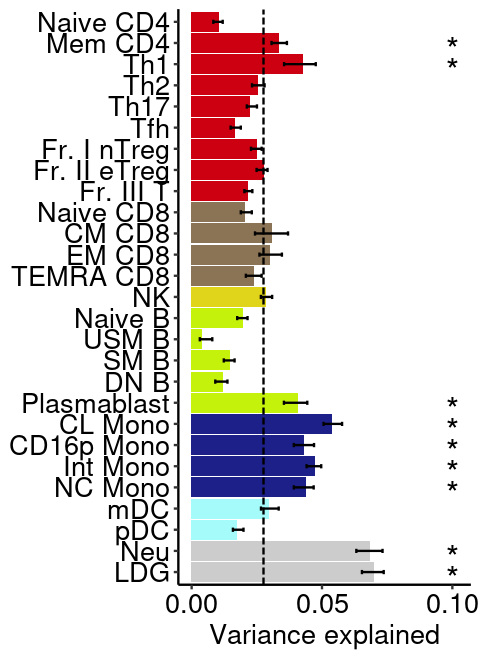

In [28]:
iii =4 # Renal

    parameter_tmp = colnames(Organ_sum_ordered)[iii+1]
    median = median(Organ_sum_ordered[,(iii+1)])

  for (kkk in 1:nrow(list)){
    subset_tmp= list$subset[kkk]
    perc_tmp  = fread_FT(list$PATH[kkk]) %>% select(test,all_of(parameter_tmp))
    percentile=quantile(perc_tmp[,2],probs=c(0.025,0.975),na.rm=T) %>% as.data.frame() %>% rownames_to_column("test")
    colnames(percentile)[2]=parameter_tmp
    perc_tmp=rbind(perc_tmp,percentile)
    perc_tmp$subset=subset_tmp
    perc_tmp=perc_tmp %>% select(subset,test,all_of(parameter_tmp))
    orig_tmp  = Organ_sum_ordered %>% filter(subset==subset_tmp) %>% 
                                      mutate(test="orig") %>% select(subset,test,all_of(parameter_tmp))

    res_tmp=rbind(orig_tmp,perc_tmp) %>% pivot_longer(col=-c(subset,test),names_to="parameter",values_to="value") %>%
                                         pivot_wider(names_from="test",values_from="value") 

    jack_tmp=as.numeric(res_tmp[1,4:(ncol(res_tmp)-2)])
    res_tmp$test_num=(ncol(res_tmp)-5)
    res_tmp$smaller_num=length(which(jack_tmp<median))
    res_tmp$median=median
    res_tmp$Pjack=(res_tmp$smaller_num/res_tmp$test_num)
    res_tmp2=res_tmp%>%select("subset","parameter","orig","2.5%","97.5%","median","test_num","smaller_num","Pjack")
    colnames(res_tmp2)[4:5]=c("lower","upper")

    if(kkk==1){res_sum=res_tmp2}else{res_sum=rbind(res_sum,res_tmp2)}
  }

res_sum$BonfP = p.adjust(res_sum$Pjack,method=("bonferroni"))

res_sum_tmp=res_sum %>% left_join(.,celltype_corresp[,1:3],by="subset")
res_sum_tmp$subset    = factor(res_sum_tmp$subset,levels=rev(celltype_reordered_27))
res_sum_tmp$lineage   = factor(res_sum_tmp$lineage,levels=c("CD4","CD8","NK","B","Monocyte","DC","Neutrophil"))
res_sum_tmp$sig=ifelse(res_sum_tmp$BonfP<0.05,"*","")

p = ggplot(data=res_sum_tmp, aes(x=subset,y=orig,ymin=lower,ymax=upper,fill=lineage))+
  geom_bar(stat="identity")+
  geom_hline(yintercept=median,col="black",linetype="longdash")+
  geom_errorbar(width=0.2)+
  geom_text(aes(label=sig,y=0.1),size=7,vjust=0.75)+
  theme_classic()+
  coord_flip()+
  #facet_wrap(~ parameter,ncol = 5)+
  scale_fill_manual(values=col2)+
  theme(axis.text.x=element_text(colour="black",size=16),
         axis.text.y=element_text(colour="black",size=16),
         axis.title.x=element_text(colour="black",size=16),
         axis.title.y=element_blank(),
         plot.title=element_blank(),
         strip.text=element_text(colour="black",size=16),
         legend.position="none")+
  scale_x_discrete(labels= label)+
  scale_y_continuous(limits=c(0,0.102),breaks= c(0,0.05,0.1))+
  labs(y="Variance explained")

options(repr.plot.width=4, repr.plot.height=5.5)
p # Fig 5c: renal activity

In [30]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /usr/local/package/r/4.0.2/lib64/R/lib/libRblas.so
LAPACK: /usr/local/package/r/4.0.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] variancePartition_1.20.0 Biobase_2.50.0           BiocGenerics_0.36.1     
 [4] scales_1.1.1             BiocParallel_1.24.1      limma_3.46.0            
 [7] lme4_1.1-27.1            Matrix_1.3-4             ggsci_2.9               
[10] RC